In [1]:
# !pip install fastaudio
# !pip install pydub

In [2]:
from google.colab import drive
drive.mount('/gdrive')
data_dir = '/gdrive/My Drive/BirdShazam/bird_data/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
from os import listdir, mkdir
import pandas as pd
wav_dir = data_dir+'wav_files/'
downloaded = pd.read_csv(data_dir+'downloaded.csv')
downloaded['filename'] = downloaded['filename'].str[:-4] + '.wav'
print(downloaded.shape)
downloaded.columns = ['filename', 'category']
train_files = listdir(wav_dir+'train')
test_files = listdir(wav_dir+'test')
df = downloaded[downloaded['filename'].isin(train_files)]
df_test = downloaded[downloaded['filename'].isin(test_files)]
print(df.shape)
print(df_test.shape)

(4619, 2)
(4156, 2)
(462, 2)


In [4]:
print(len(df['category'].unique()), 'different classes')

25 different classes


In [5]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci

torch.cuda.empty_cache()

path = Path('.')
seconds = 15
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512)
a2s = AudioToSpec.from_cfg(cfg)
# item_transforms = [ResizeSignal(seconds*1000, pad_mode=AudioPadType.Repeat), a2s]
item_transforms = [a2s]

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:47: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  '"torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. '
/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:358: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  "At least one mel filterbank has all zero values. "


In [6]:
train_dir = wav_dir+'train'
auds = DataBlock(blocks = (AudioBlock(crop_signal_to=seconds*1000), CategoryBlock),
                 get_x = ColReader("filename", pref=path/train_dir), 
                 splitter = TrainTestSplitter(random_state=42, stratify=df['category'], test_size=0.2),
                 item_tfms = item_transforms,
                 get_y = ColReader("category")
                 )

In [7]:
batch_size = 64
dbunch = auds.dataloaders(df, bs=batch_size, shuffle=False, seed=42)

In [8]:
set_seed(42,True)
dbunch.rng.seed(42)

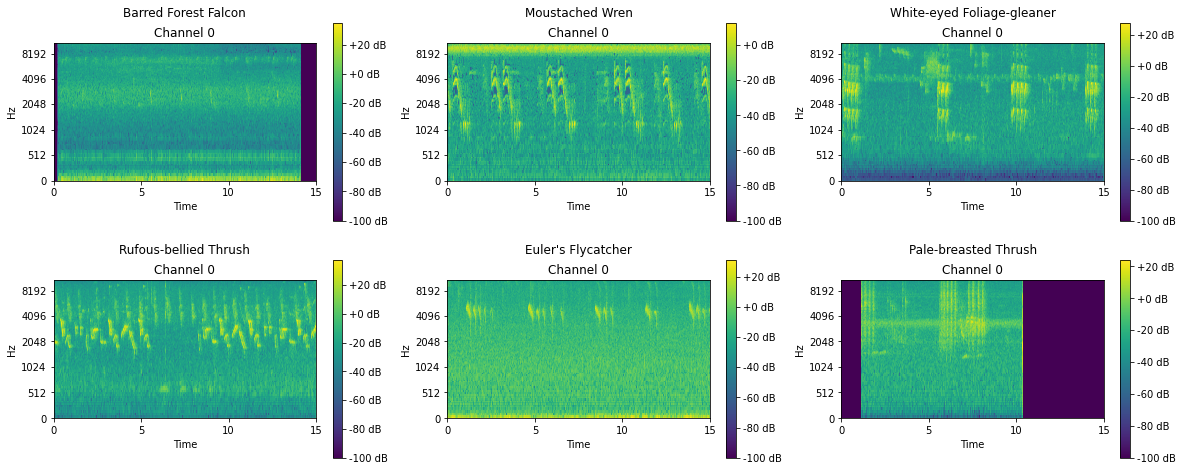

In [9]:
dbunch.show_batch(figsize=(20, 8), nrows=2, ncols=3)

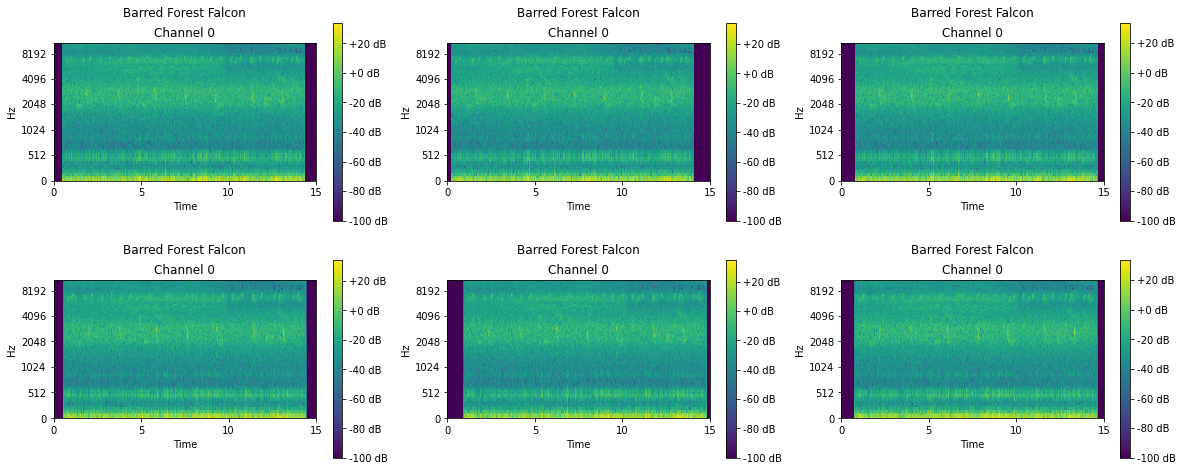

In [10]:
dbunch.show_batch(figsize=(20, 8), nrows=2, ncols=3, unique=True)

In [11]:
model_type = resnet34
learn = cnn_learner(dbunch, 
            model_type,
            n_in=1,
            loss_func=CrossEntropyLossFlat(),
            metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

0.0010000000149011613


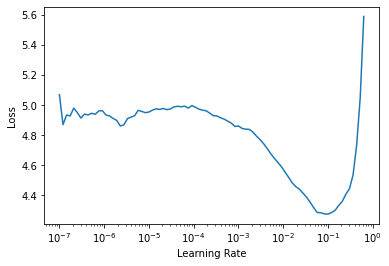

In [12]:
lr = learn.lr_find()[0]/10
print(lr)

In [ ]:
callbacks = [SaveModelCallback(), ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2), EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=4)]
learn.fine_tune(20, wd=0.1, base_lr=lr, cbs=callbacks)

epoch,train_loss,valid_loss,accuracy,time
0,4.263346,2.748312,0.254808,24:36


Better model found at epoch 0 with valid_loss value: 2.748311758041382.


epoch,train_loss,valid_loss,accuracy,time
0,3.219463,2.301339,0.355769,24:13
1,2.783533,1.962582,0.419471,23:50
2,2.289498,1.528728,0.567308,23:50
3,1.811831,1.239731,0.657452,23:51
4,1.391595,1.083148,0.683894,26:19


Better model found at epoch 0 with valid_loss value: 2.3013386726379395.
Better model found at epoch 1 with valid_loss value: 1.9625821113586426.
Better model found at epoch 2 with valid_loss value: 1.5287280082702637.
Better model found at epoch 3 with valid_loss value: 1.2397308349609375.
Better model found at epoch 4 with valid_loss value: 1.0831483602523804.


In [ ]:
learn.save('model0')

In [ ]:
learn.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
interp.most_confused()[:10]

In [ ]:
test_dir = wav_dir+'test'
auds_test = DataBlock(blocks = (AudioBlock(crop_signal_to=seconds*1000), CategoryBlock),  
                 get_x = ColReader("filename", pref=path/test_dir),
                 item_tfms = item_transforms,
                 get_y = ColReader("category")
                 )

dbunch_test = auds_test.dataloaders(df_test, bs=batch_size, shuffle=False, seed=42)

In [ ]:
learn = cnn_learner(dbunch_test, 
            model_type,
            n_in=1,
            loss_func=CrossEntropyLossFlat(),
            metrics=[accuracy])
learn.load('model0')
dbunch_test.rng.seed(42)
set_seed(42,True)

In [ ]:
learn.data = dbunch_test
preds1, y = learn.get_preds(dl=dbunch_test[0])
acc1 = accuracy(preds1, y)
acc1

In [ ]:
learn.data = dbunch_test
preds2, y = learn.get_preds(dl=dbunch_test[1])
acc2 = accuracy(preds2, y)
acc2

In [ ]:
preds1.shape[0] + preds2.shape[0]

In [ ]:
(acc1*preds1.shape[0] + acc2*preds2.shape[0])/(preds1.shape[0] + preds2.shape[0])